In [1]:
import numpy as np
import pandas as pd
import datetime
import pickle
import re

# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline
sns.set()

# 統計モデル
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# 線形回帰
from sklearn import linear_model

# 誤差の評価
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# ワーニングを表示させない
import warnings
warnings.filterwarnings('ignore')

In [2]:
inputDir = "/home/onimem/work/Open_world/NBA/Graph"
outputDir = "/home/onimem/work/Open_world/NBA/Model"

# primary attribute
PA = 'Tm'
# primary attribute contents
PAC = ['ATL', 'BRK', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHO', 'PHI', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']

# 誤差辞書
error = {}
error['new node'] = {}
error['new node']['true'] = []
error['new node']['pred'] = []
ERROR_NN_T = error['new node']['true']
ERROR_NN_P = error['new node']['pred']

# 時系列グラフの読み込み
with open(inputDir + '/nba.graph', mode='rb') as f:
    graph = pickle.load(f)

In [3]:
def plot_history(history, x, y, title):
    plt.plot(history[x], history[y], marker=".", label=y, color='#1ea8b5')
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()
    
def plot_history2(history, x, y1, y2, title, ylabel):
    plt.plot(history[x], history[y1], marker=".", color='#1ea8b5', label=y1)
    plt.plot(history[x], history[y2], marker=".", color='#ce405f', label=y2)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [4]:
def is_unique(seq):
    return len(seq) == len(set(seq))

def new_node(y1nodes, y2nodes):
    if is_unique(y1nodes) and is_unique(y2nodes):
        newnodes = set(y2nodes) - set(y1nodes)
        return len(newnodes)
    else :
        print("error")
        exit()

def loss_node(y1nodes, y2nodes):
    if is_unique(y1nodes) and is_unique(y2nodes):
        lossnodes = set(y1nodes) - set(y2nodes)
        return len(lossnodes)
    else :
        print("error")
        exit()

In [5]:
def GroupByPA(years, graph):
    panodes = {}
    for pac in PAC:
        panodes[pac] = {}
        for year in range(years[0]-1, years[-1]+1):
            panodes[pac][year] = {}
            for name, attribute in graph[year]['nodes'].items():
                if attribute[PA] == pac:
                    panodes[pac][year][name] = graph[year]['nodes'][name]
    return panodes

def LinearRegression(train_year, new_nodes_train, years_all):
    
    # 訓練期間で学習
    X = pd.DataFrame(train_year)
    Y = pd.DataFrame(new_nodes_train)
    model = linear_model.LinearRegression()
    model.fit(X, Y)
    
    # 予測 (全ての年にモデルを適用)
    px = np.array(years_all)[:,np.newaxis] # sklearnの仕様のため二次元numpy配列に変換
    py = model.predict(px)
    py = py.reshape(-1).tolist()
    return py

In [6]:
def PredictNodeNum(years_all, train_year, test_year, graph):
    
    # 結果格納用リスト
    true_ls = []
    pred_ls = []
    num_per_pac = {}
    
    # primary attributeでグルーピング ( return : panodes[pac][year][name] )
    panodes = GroupByPA(years_all, graph)
    
    # primary attribute ごとに予測
    for pac, nodes in panodes.items():
        # pac : primary attributeが取りうる一つの属性値
        # nodes[year][name] : (primary属性=pac)のノード集合
        
        # 期間全体 years_all, new_nodes_all
        new_nodes_all = []
        for year in years_all:
            diff = new_node(nodes[year-1], nodes[year])
            new_nodes_all.append(diff)
        
        # 訓練用 train_year, new_nodes_train
        new_nodes_train = []
        for year in train_year:
            diff = new_node(nodes[year-1], nodes[year])
            new_nodes_train.append(float(diff))
        
        # 学習＆予測
        pred = LinearRegression(train_year, new_nodes_train, years_all)
        
        # 結果をプロット
        history = {'year':years_all, 'true':new_nodes_all, 'pred':pred}
        plot_history2(history, 'year', 'true', 'pred', title=pac, ylabel="#player")
        
        # テスト期間のみの予測数を四捨五入してから辞書に格納
        num_per_pac[pac] = list(map(lambda x: round(x), pred[len(train_year):]))
        
        # 誤差を記録
        for i in range(len(test_year)):
            true_ls.append(new_nodes_all[-1-i])
            pred_ls.append(list(pred)[-1-i])
        
    return num_per_pac, true_ls, pred_ls

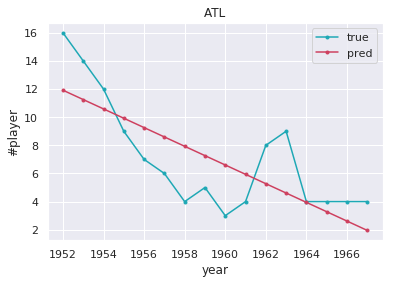

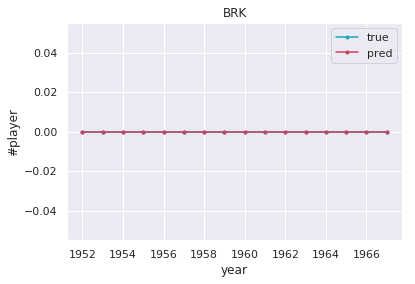

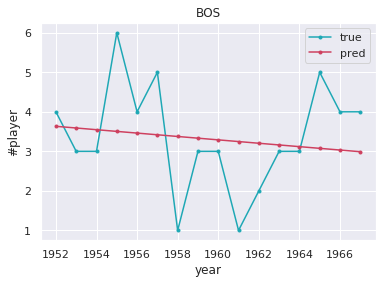

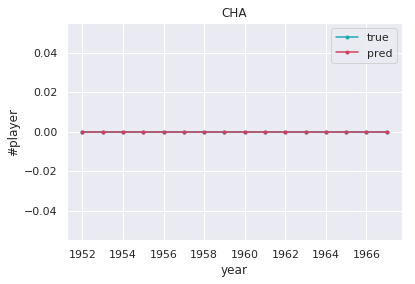

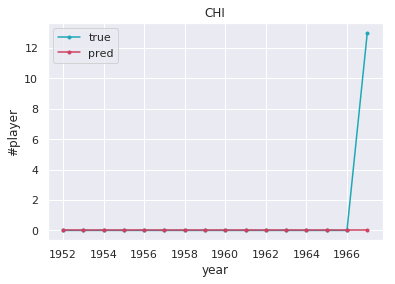

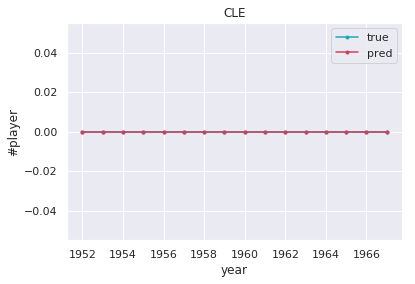

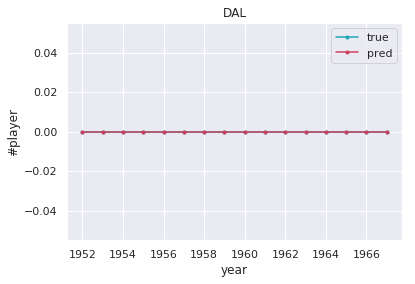

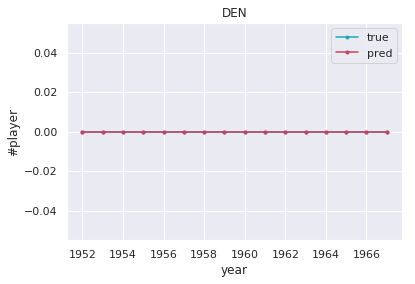

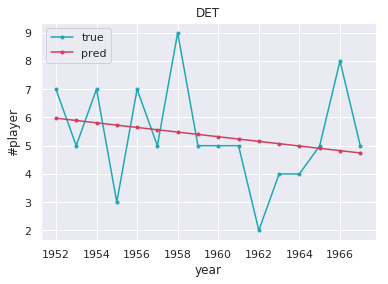

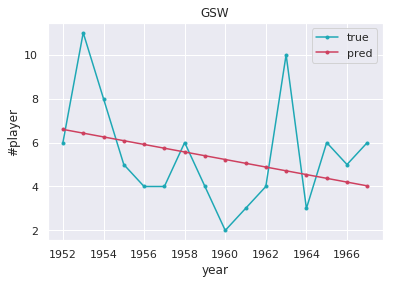

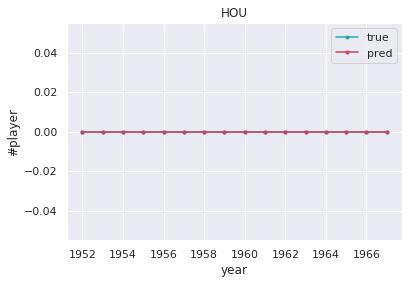

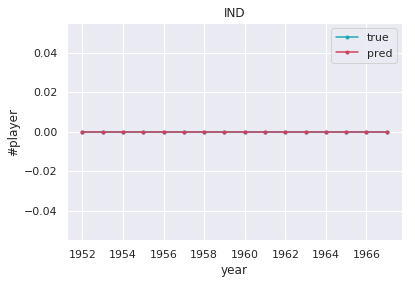

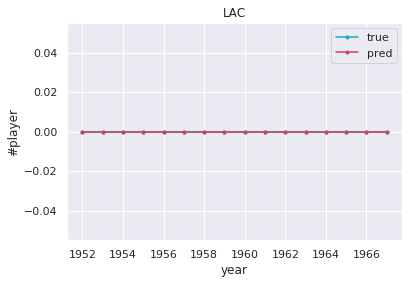

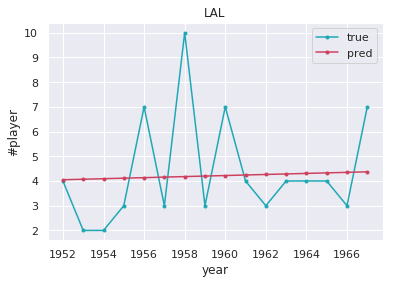

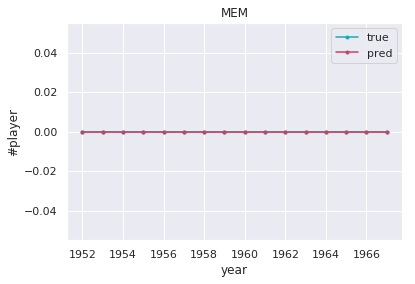

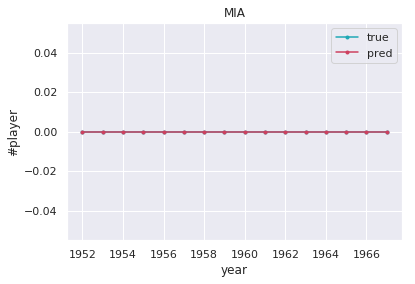

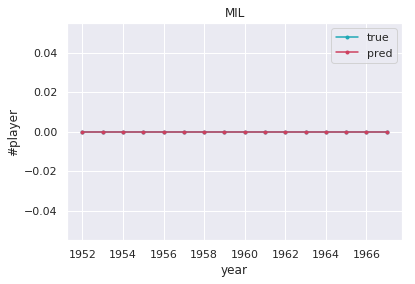

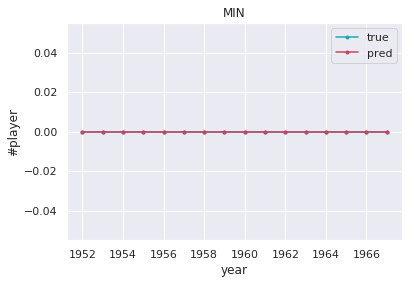

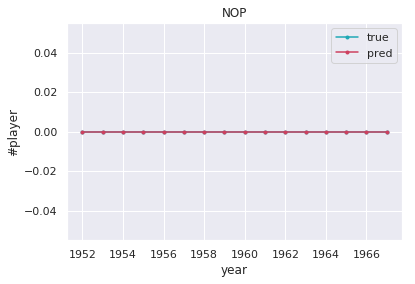

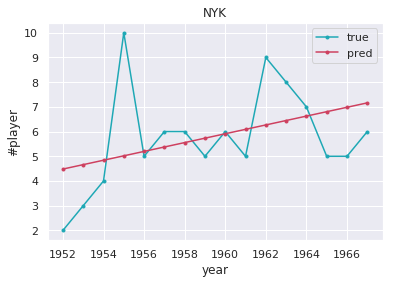

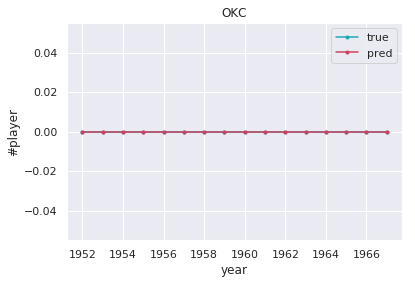

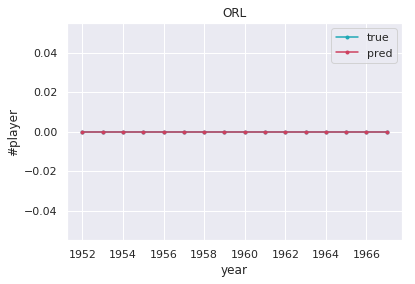

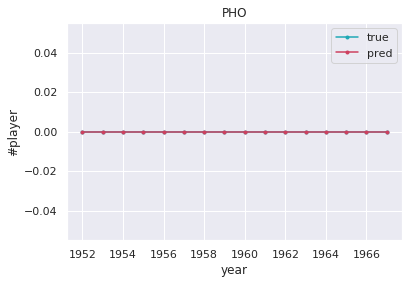

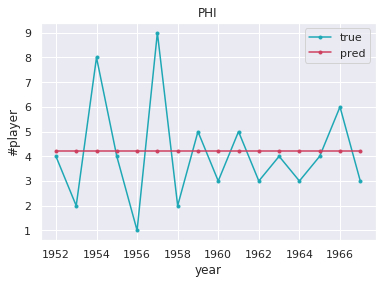

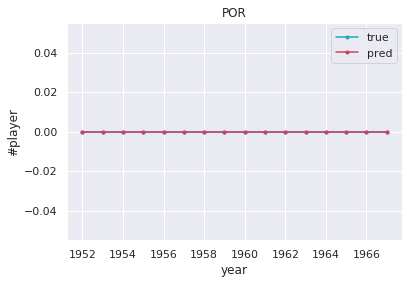

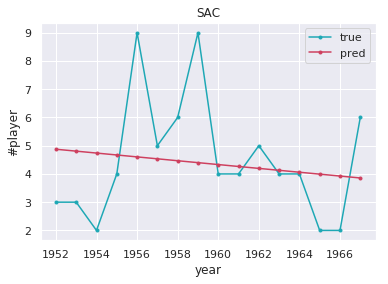

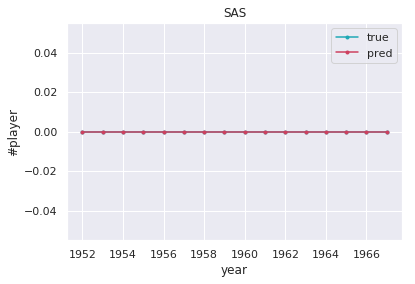

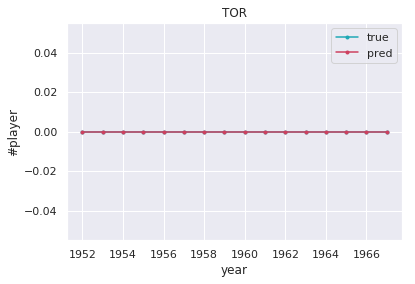

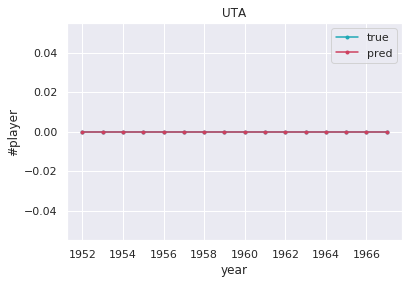

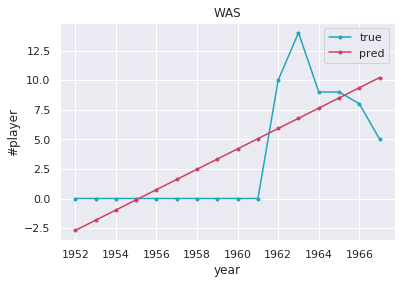

{'ATL': [2], 'BRK': [0], 'BOS': [3], 'CHA': [0], 'CHI': [0], 'CLE': [0], 'DAL': [0], 'DEN': [0], 'DET': [5], 'GSW': [4], 'HOU': [0], 'IND': [0], 'LAC': [0], 'LAL': [4], 'MEM': [0], 'MIA': [0], 'MIL': [0], 'MIN': [0], 'NOP': [0], 'NYK': [7], 'OKC': [0], 'ORL': [0], 'PHO': [0], 'PHI': [4], 'POR': [0], 'SAC': [4], 'SAS': [0], 'TOR': [0], 'UTA': [0], 'WAS': [10]}
NewNodePredError MAE 1.0212698412698418
NewNodePredError MSE 7.323141345427061
NewNodePredError RMSE 2.7061303267631183


In [8]:
# 過去Mステップから将来Hステップを予測する
M = 15
H = 1
#years = [i for i in range(1952, 2018-(M+H-1))] 
years = [i for i in range(1952, 1968-(M+H-1))]

for year in years:
    # 訓練期間 : Mステップ
    train_year = [(year+m) for m in range(M)]
    # テスト期間 : Hステップ
    test_year = [(train_year[-1]+h+1) for h in range(H)]
    # 期間全体 : M+Hステップ
    years_all = train_year.copy()
    years_all.extend(test_year)
       
    # primary属性ごとに将来出現するノード数を予測
    num_per_pac, true_ls, pred_ls = PredictNodeNum(years_all, train_year, test_year, graph)
    
    # 出現ノード数予測についての誤差を記録
    ERROR_NN_T.extend(true_ls)
    ERROR_NN_P.extend(pred_ls)    
    
    print(num_per_pac)

    
print("NewNodePredError MAE", mean_absolute_error(ERROR_NN_T, ERROR_NN_P))
print("NewNodePredError MSE", mean_squared_error(ERROR_NN_T, ERROR_NN_P))
print("NewNodePredError RMSE", np.sqrt(mean_squared_error(ERROR_NN_T, ERROR_NN_P)))    